    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed PrettyPrint ───────── v0.2.0
   Installed RealDot ───────────── v0.1.0
   Installed ZygoteRules ───────── v0.2.7
   Installed ShowCases ─────────── v0.1.0
   Installed ContextVariablesX ─── v0.1.3
   Installed MLUtils ───────────── v0.4.8
   Installed Accessors ─────────── v0.1.42
   Installed InitialValues ─────── v0.3.1
   Installed MLCore ────────────── v1.0.0
   Installed DefineSingletons ──── v0.1.2
   Installed FLoopsBase ────────── v0.1.1
   Installed OneHotArrays ──────── v0.2.10
   Installed IRTools ───────────── v0.4.15
   Installed MicroCollections ──── v0.2.0
   Installed ProgressLogging ───── v0.1.5
   Installed Zygote ────────────── v0.7.10
   Installed NameResolution ────── v0.1.5
   Installed CompositionsBase ──── v0.1.2
   Installed JuliaVariables ────── v0.2.4
   Installed BangBang ──────────── v0.4.6
   Installed ChainRules ────────── v1.72.6
   Installed MLStyle

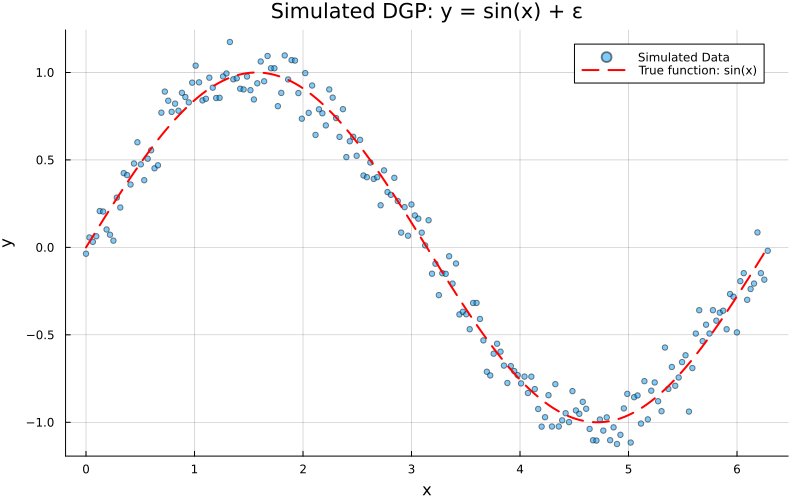

Data simulated: 200 observations
x range: [0.00, 6.28]
y range: [-1.12, 1.17]

Training NN with relu activation...


┌ Warning: `Flux.params(m...)` is deprecated. Use `Flux.trainable(model)` for parameter collection,
│ and the explicit `gradient(m -> loss(m, x, y), model)` for gradient computation.
└ @ Flux ~/.julia/packages/Flux/uRn8o/src/deprecations.jl:93
┌ Warning: Implicit gradients such as `withgradient(f, ::Params)` are deprecated in Flux!
│ Please see the docs for new explicit form.
│   caller = train_model!(model::Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, X::Matrix{Float64}, y::Matrix{Float64}, epochs::Int64, lr::Float64) at In[4]:95
└ @ Main ./In[4]:95
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 50, relu)  # 100 parameters
│   summary(x) = "1×200 Matrix{Float64}"
└ @ Flux ~/.julia/packag

LoadError: Invalid input to `update!`.
 `update!(state, model, grad)` needs `state = Flux.setup(opt, model)`.


In [4]:
# Question 1 - NN Basics # Part I: Fitting Data
# INSTALACIÓN DE PAQUETES (ejecutar solo la primera vez)

using Pkg
Pkg.add(["Flux", "Plots", "Statistics", "Printf"])

# =============================================================================
# IMPORTAR LIBRERÍAS
# =============================================================================

using Random
using Plots
using Flux
using Statistics
using Printf

# Set random seed for reproducibility
Random.seed!(42)

# =============================================================================
# 1. SIMULATION OF DGP: y = sin(x) + ε
# =============================================================================

# Generate x values in [0, 2π]
n_samples = 200
x = range(0, 2π, length=n_samples)

# Generate noise
epsilon = randn(n_samples) .* 0.1

# Generate y values
y = sin.(x) .+ epsilon

# Plot simulated data
p1 = scatter(x, y, alpha=0.5, ms=3, label="Simulated Data",
             xlabel="x", ylabel="y",
             title="Simulated DGP: y = sin(x) + ε",
             legend=:topright, grid=true, gridalpha=0.3,
             size=(800, 500))
plot!(p1, x, sin.(x), lw=2, ls=:dash, color=:red, label="True function: sin(x)")
savefig(p1, "simulated_data.png")
display(p1)

println("Data simulated: $n_samples observations")
@printf("x range: [%.2f, %.2f]\n", minimum(x), maximum(x))
@printf("y range: [%.2f, %.2f]\n", minimum(y), maximum(y))

# =============================================================================
# 2. TRAIN NEURAL NETWORKS WITH DIFFERENT ACTIVATION FUNCTIONS
# =============================================================================

# Define NN architecture: 3 hidden layers, 50 neurons each
hidden_sizes = [50, 50, 50]
max_epochs = 2000
learning_rate = 0.001

# Prepare data for Flux
X_train = reshape(collect(x), 1, :)  # 1 x n_samples
y_train = reshape(y, 1, :)

# Dictionary to store models and predictions
models = Dict()
predictions = Dict()

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

# Function to create a neural network
function create_model(activation, input_dim, hidden_sizes, output_dim)
    layers = []

    # First hidden layer
    push!(layers, Dense(input_dim, hidden_sizes[1], activation))

    # Additional hidden layers
    for i in 2:length(hidden_sizes)
        push!(layers, Dense(hidden_sizes[i-1], hidden_sizes[i], activation))
    end

    # Output layer
    push!(layers, Dense(hidden_sizes[end], output_dim))

    return Chain(layers...)
end

# Function to train model
function train_model!(model, X, y, epochs, lr)
    opt = Adam(lr)
    params_model = Flux.params(model)

    losses = Float64[]

    for epoch in 1:epochs
        loss_val, grads = Flux.withgradient(params_model) do
            ŷ = model(X)
            Flux.mse(ŷ, y)
        end

        Flux.update!(opt, params_model, grads)
        push!(losses, loss_val)

        if epoch % 200 == 0
            @printf("Epoch %d: Loss = %.6f\n", epoch, loss_val)
        end
    end

    return losses
end

# MSE function
function mse(y_true, y_pred)
    return mean((y_true .- y_pred).^2)
end

# =============================================================================
# ENTRENAR MODELOS CON DIFERENTES FUNCIONES DE ACTIVACIÓN
# =============================================================================

# Activation functions to test
activation_functions = Dict(
    "logistic" => σ,      # sigmoid
    "tanh" => tanh,
    "relu" => relu
)

# Train NNs with each activation function
for (name, activation) in activation_functions
    println("\nTraining NN with $name activation...")

    # Create model
    model = create_model(activation, 1, hidden_sizes, 1)

    # Train model
    losses = train_model!(model, X_train, y_train, max_epochs, learning_rate)

    # Store model and predictions
    models[name] = model
    predictions[name] = vec(model(X_train))

    # Print training info
    println("Training completed in $max_epochs iterations")
    @printf("Final loss: %.6f\n", losses[end])
end

# Train NN with mixed activation functions (one per layer)
println("\nTraining NN with mixed activation functions...")
println("Creating model with different activations per layer: relu, tanh, sigmoid")

# Create mixed model manually
model_mixed = Chain(
    Dense(1, 50, relu),
    Dense(50, 50, tanh),
    Dense(50, 50, σ),
    Dense(50, 1)
)

losses_mixed = train_model!(model_mixed, X_train, y_train, max_epochs, learning_rate)
predictions["mixed"] = vec(model_mixed(X_train))

println("Training completed in $max_epochs iterations")
@printf("Final loss: %.6f\n", losses_mixed[end])

# =============================================================================
# 3. PLOT RESULTS FOR EACH ACTIVATION FUNCTION
# =============================================================================

activation_list = ["logistic", "tanh", "relu", "mixed"]
titles = ["Logistic Activation", "Tanh Activation", "ReLU Activation",
          "Mixed Activations (ReLU-Tanh-Sigmoid)"]

plots_array = []

for (activation, title) in zip(activation_list, titles)
    p = scatter(x, y, alpha=0.4, ms=3, label="Data", color=:blue,
                xlabel="x", ylabel="y", title=title,
                legend=:topright, grid=true, gridalpha=0.3)

    # Plot true function
    plot!(p, x, sin.(x), lw=2, ls=:dash, color=:green,
          label="True: sin(x)", alpha=0.7)

    # Plot fitted values
    plot!(p, x, predictions[activation], lw=2, color=:red,
          label="NN Prediction", alpha=0.8)

    push!(plots_array, p)
end

p_combined = plot(plots_array..., layout=(2,2), size=(1200, 900))
savefig(p_combined, "nn_comparison_activations.png")
display(p_combined)

# =============================================================================
# COMPARAR MSE PARA CADA MODELO
# =============================================================================

println("\n" * "="^60)
println("MODEL COMPARISON - Mean Squared Error (MSE)")
println("="^60)

mse_results = Dict()
for activation in activation_list
    mse_val = mse(y, predictions[activation])
    mse_results[activation] = mse_val
    @printf("%-15s: MSE = %.6f\n", activation, mse_val)
end

best_activation = argmin(mse_results)
println("\n" * "="^60)
println("BEST PERFORMING: $(uppercase(best_activation)) (Lowest MSE)")
println("="^60)

# Answer to the question
println("\nANSWER: Which NN fits the data better?")
println("-" ^ 60)
println("The neural network with $(uppercase(best_activation)) activation function")
@printf("performs best with MSE = %.6f\n", mse_results[best_activation])
println("\nGenerally, ReLU tends to perform well because:")
println("- It avoids vanishing gradient problems")
println("- It's computationally efficient")
println("- It allows for faster convergence")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


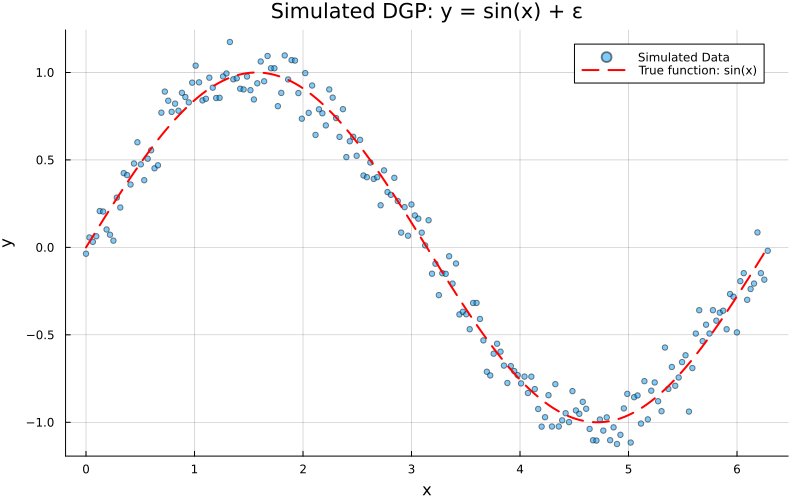

Data simulated: 200 observations
x range: [0.00, 6.28]
y range: [-1.12, 1.17]

Training NN with relu activation...
Epoch 200: Loss = 0.103689
Epoch 400: Loss = 0.018536
Epoch 600: Loss = 0.008146
Epoch 800: Loss = 0.007888
Epoch 1000: Loss = 0.007790
Epoch 1200: Loss = 0.007736
Epoch 1400: Loss = 0.007659
Epoch 1600: Loss = 0.007638
Epoch 1800: Loss = 0.007589
Epoch 2000: Loss = 0.007558
Training completed in 2000 iterations
Final loss: 0.007558

Training NN with logistic activation...
Epoch 200: Loss = 0.222969
Epoch 400: Loss = 0.177807
Epoch 600: Loss = 0.141786
Epoch 800: Loss = 0.086177
Epoch 1000: Loss = 0.046654
Epoch 1200: Loss = 0.032819
Epoch 1400: Loss = 0.015584
Epoch 1600: Loss = 0.010099
Epoch 1800: Loss = 0.009145
Epoch 2000: Loss = 0.008956
Training completed in 2000 iterations
Final loss: 0.008956

Training NN with tanh activation...
Epoch 200: Loss = 0.090768
Epoch 400: Loss = 0.023632
Epoch 600: Loss = 0.009186
Epoch 800: Loss = 0.009103
Epoch 1000: Loss = 0.009073
E

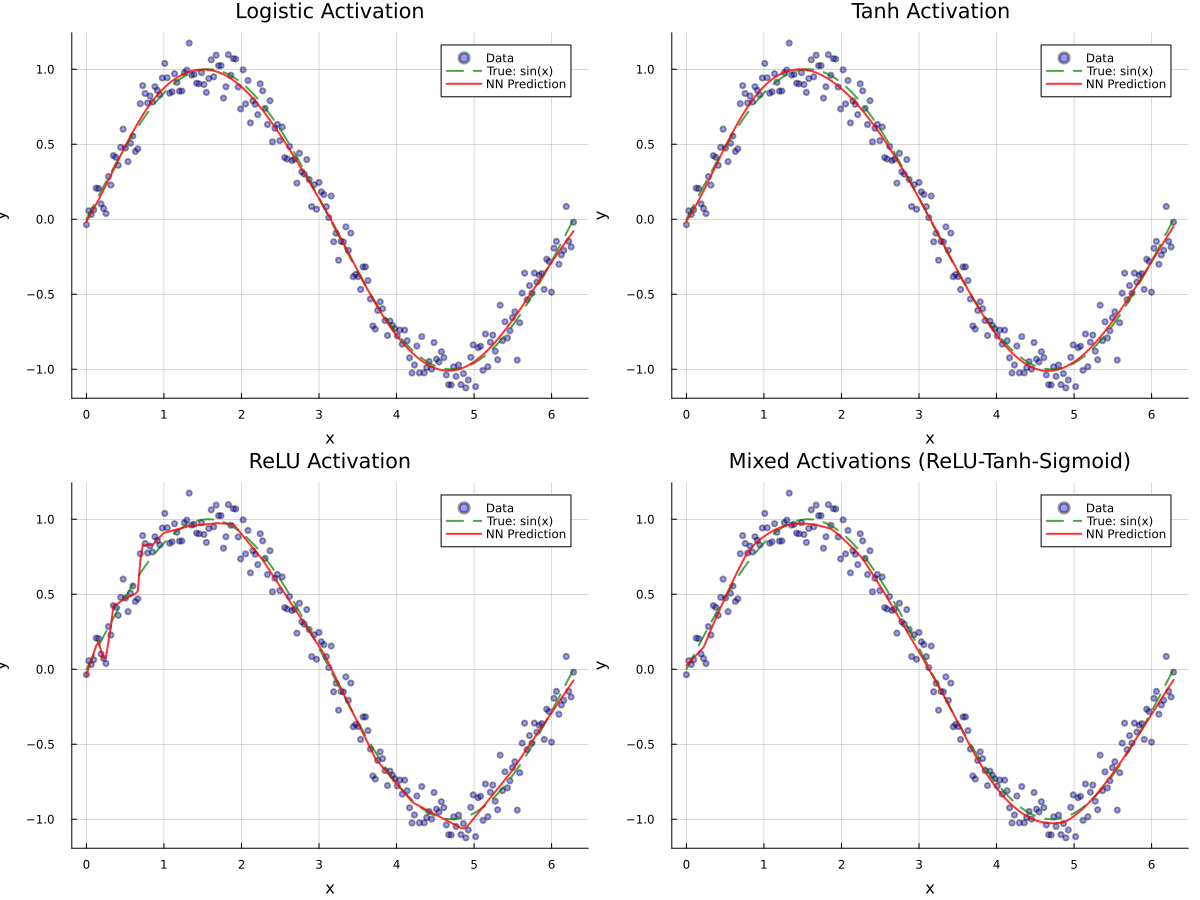


MODEL COMPARISON - Mean Squared Error (MSE)
logistic       : MSE = 0.008956
tanh           : MSE = 0.009026
relu           : MSE = 0.007560
mixed          : MSE = 0.008855

BEST PERFORMING: RELU (Lowest MSE)

ANSWER: Which NN fits the data better?
------------------------------------------------------------
The neural network with RELU activation function
performs best with MSE = 0.007560

Generally, ReLU tends to perform well because:
- It avoids vanishing gradient problems
- It's computationally efficient
- It allows for faster convergence



LEARNING RATE EXPLANATION
The learning rate (α) is a hyperparameter that controls how much the model's
weights are adjusted during training in response to the estimated error.

- SMALL learning rate (e.g., 0.0001):
  • More stable training
  • Slower convergence
  • May get stuck in local minima

- LARGE learning rate (e.g., 0.1):
  • Faster initial progress
  • Risk of overshooting optimal values
  • May cause unstable training or divergence



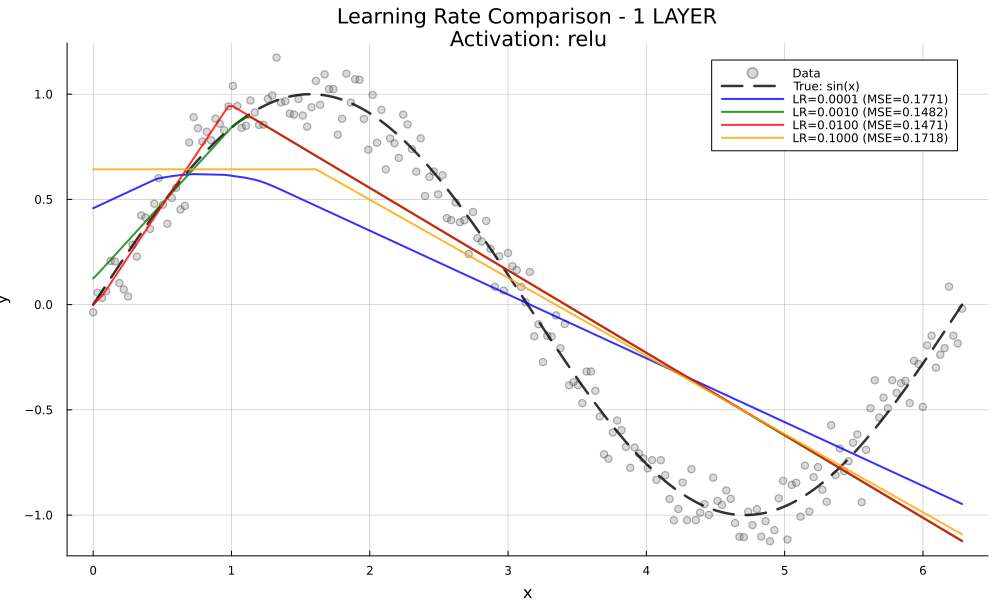


Best learning rate for 1 layer: 0.0100 (MSE=0.147083)


Training NNs with 2 layers - 50 neurons each
------------------------------------------------------------
Learning rate: 0.0001
Epoch 200: Loss = 0.328828
Epoch 400: Loss = 0.239136
Epoch 600: Loss = 0.170836
Epoch 800: Loss = 0.142369
Epoch 1000: Loss = 0.135662
Epoch 1200: Loss = 0.132913
Epoch 1400: Loss = 0.130006
Epoch 1600: Loss = 0.126433
Epoch 1800: Loss = 0.122025
Epoch 2000: Loss = 0.116806
  Iterations: 2000, MSE: 0.116777
Learning rate: 0.001
Epoch 200: Loss = 0.147124
Epoch 400: Loss = 0.147064
Epoch 600: Loss = 0.147050
Epoch 800: Loss = 0.147026
Epoch 1000: Loss = 0.147024
Epoch 1200: Loss = 0.147015
Epoch 1400: Loss = 0.147094
Epoch 1600: Loss = 0.147016
Epoch 1800: Loss = 0.147016
Epoch 2000: Loss = 0.147014
  Iterations: 2000, MSE: 0.147013
Learning rate: 0.01
Epoch 200: Loss = 0.016378
Epoch 400: Loss = 0.008922
Epoch 600: Loss = 0.008361
Epoch 800: Loss = 0.008247
Epoch 1000: Loss = 0.011079
Epoch 1200: Loss =

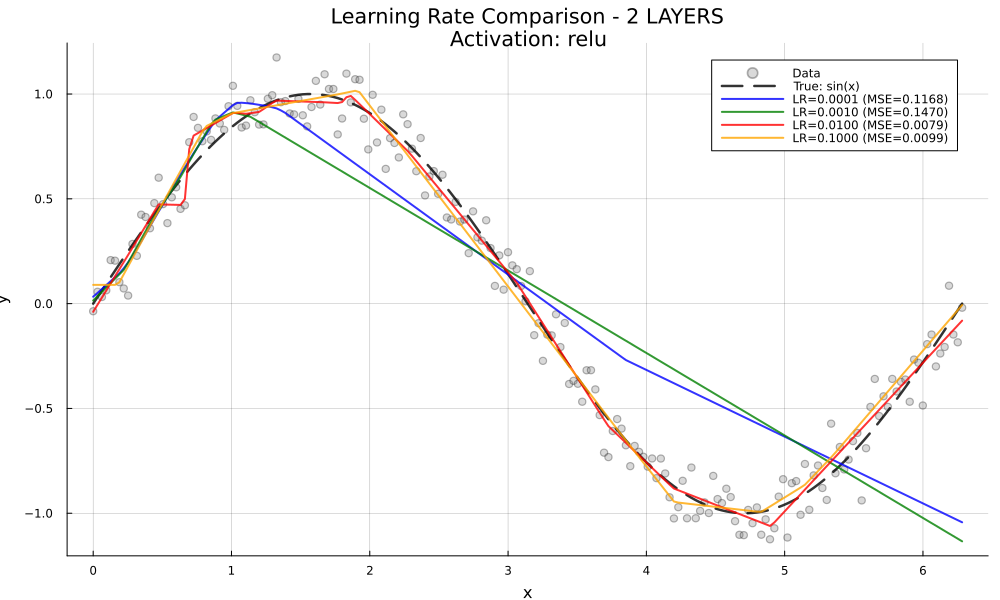


Best learning rate for 2 layers: 0.0100 (MSE=0.007920)


Training NNs with 3 layers - 50 neurons each
------------------------------------------------------------
Learning rate: 0.0001
Epoch 200: Loss = 0.310441
Epoch 400: Loss = 0.186643
Epoch 600: Loss = 0.127279
Epoch 800: Loss = 0.117290
Epoch 1000: Loss = 0.110517
Epoch 1200: Loss = 0.102108
Epoch 1400: Loss = 0.086940
Epoch 1600: Loss = 0.067090
Epoch 1800: Loss = 0.046169
Epoch 2000: Loss = 0.028515
  Iterations: 2000, MSE: 0.028441
Learning rate: 0.001
Epoch 200: Loss = 0.050730
Epoch 400: Loss = 0.008561
Epoch 600: Loss = 0.008195
Epoch 800: Loss = 0.008007
Epoch 1000: Loss = 0.007836
Epoch 1200: Loss = 0.007742
Epoch 1400: Loss = 0.007682
Epoch 1600: Loss = 0.007658
Epoch 1800: Loss = 0.007709
Epoch 2000: Loss = 0.007620
  Iterations: 2000, MSE: 0.007614
Learning rate: 0.01
Epoch 200: Loss = 0.009820
Epoch 400: Loss = 0.009272
Epoch 600: Loss = 0.009268
Epoch 800: Loss = 0.010175
Epoch 1000: Loss = 0.008255
Epoch 1200: Loss 

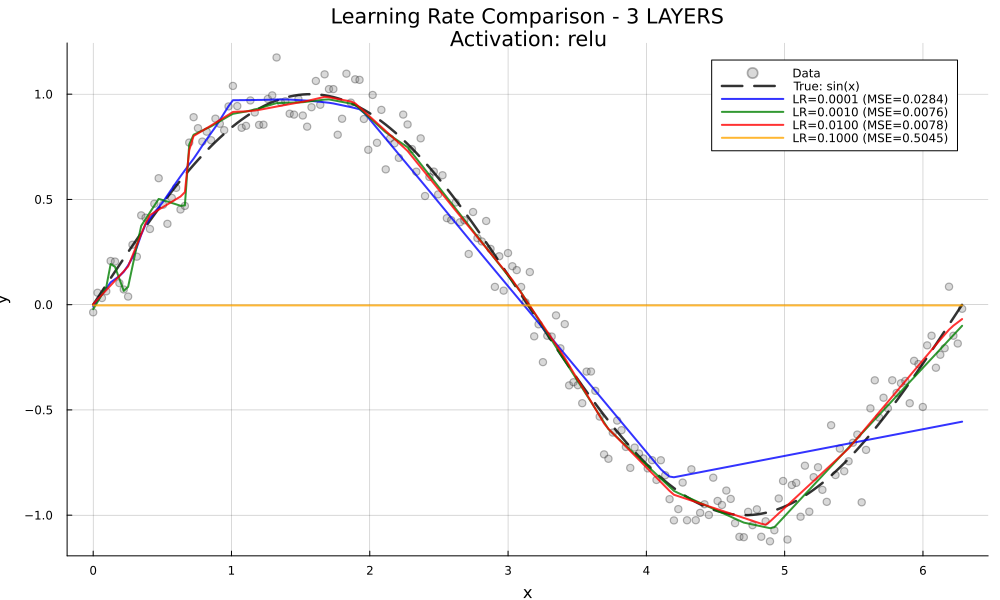


Best learning rate for 3 layers: 0.0010 (MSE=0.007614)


RELATIONSHIP BETWEEN LEARNING RATE AND NUMBER OF HIDDEN LAYERS
Based on this illustrative example, we can observe:

1. LEARNING RATE SENSITIVITY:
   - Very small LR (0.0001): May not converge in limited iterations,
     especially with more layers (longer paths for gradient backpropagation)

   - Small LR (0.001): Generally stable across all layer configurations,
     good baseline choice

   - Medium LR (0.01): Often performs well, but may show instability
     with deeper networks

   - Large LR (0.1): Risk of divergence, especially problematic with
     deeper networks due to gradient explosion

2. DEPTH vs LEARNING RATE:
   - Deeper networks (more layers) are MORE SENSITIVE to learning rate
   - With more layers, gradients must propagate through longer paths
   - This can lead to:
     * Vanishing gradients (if LR too small)
     * Exploding gradients (if LR too large)

3. PRACTICAL RECOMMENDATIONS:
   - Start with moderate 

In [6]:
# Question 1 - NN Basics # Part I: Fitting Data
# INSTALACIÓN DE PAQUETES (ejecutar solo la primera vez)

using Pkg
Pkg.add(["Flux", "Plots", "Statistics", "Printf"])

# =============================================================================
# IMPORTAR LIBRERÍAS
# =============================================================================

using Random
using Plots
using Flux
using Statistics
using Printf

# Set random seed for reproducibility
Random.seed!(42)

# =============================================================================
# 1. SIMULATION OF DGP: y = sin(x) + ε
# =============================================================================

# Generate x values in [0, 2π]
n_samples = 200
x = range(0, 2π, length=n_samples)

# Generate noise
epsilon = randn(n_samples) .* 0.1

# Generate y values
y = sin.(x) .+ epsilon

# Plot simulated data
p1 = scatter(x, y, alpha=0.5, ms=3, label="Simulated Data",
             xlabel="x", ylabel="y",
             title="Simulated DGP: y = sin(x) + ε",
             legend=:topright, grid=true, gridalpha=0.3,
             size=(800, 500))
plot!(p1, x, sin.(x), lw=2, ls=:dash, color=:red, label="True function: sin(x)")
savefig(p1, "simulated_data.png")
display(p1)

println("Data simulated: $n_samples observations")
@printf("x range: [%.2f, %.2f]\n", minimum(x), maximum(x))
@printf("y range: [%.2f, %.2f]\n", minimum(y), maximum(y))

# =============================================================================
# 2. TRAIN NEURAL NETWORKS WITH DIFFERENT ACTIVATION FUNCTIONS
# =============================================================================

# Define NN architecture: 3 hidden layers, 50 neurons each
hidden_sizes = [50, 50, 50]
max_epochs = 2000
learning_rate = 0.001

# Prepare data for Flux (convert to Float32 for consistency)
X_train = Float32.(reshape(collect(x), 1, :))  # 1 x n_samples
y_train = Float32.(reshape(y, 1, :))

# Dictionary to store models and predictions
models = Dict()
predictions = Dict()

# =============================================================================
# FUNCIONES AUXILIARES
# =============================================================================

# Function to create a neural network
function create_model(activation, input_dim, hidden_sizes, output_dim)
    layers = []

    # First hidden layer
    push!(layers, Dense(input_dim, hidden_sizes[1], activation))

    # Additional hidden layers
    for i in 2:length(hidden_sizes)
        push!(layers, Dense(hidden_sizes[i-1], hidden_sizes[i], activation))
    end

    # Output layer
    push!(layers, Dense(hidden_sizes[end], output_dim))

    return Chain(layers...)
end

# Function to train model (NUEVA API de Flux)
function train_model!(model, X, y, epochs, lr)
    opt = Adam(lr)
    # Nueva API: usar setup en lugar de params
    opt_state = Flux.setup(opt, model)

    losses = Float64[]

    for epoch in 1:epochs
        # Nueva API: gradiente explícito
        loss_val, grads = Flux.withgradient(model) do m
            ŷ = m(X)
            Flux.mse(ŷ, y)
        end

        # Nueva API: update! con state
        Flux.update!(opt_state, model, grads[1])
        push!(losses, loss_val)

        if epoch % 200 == 0
            @printf("Epoch %d: Loss = %.6f\n", epoch, loss_val)
        end
    end

    return losses
end

# MSE function
function mse(y_true, y_pred)
    return mean((y_true .- y_pred).^2)
end

# =============================================================================
# ENTRENAR MODELOS CON DIFERENTES FUNCIONES DE ACTIVACIÓN
# =============================================================================

# Activation functions to test
activation_functions = Dict(
    "logistic" => σ,      # sigmoid
    "tanh" => tanh,
    "relu" => relu
)

# Train NNs with each activation function
for (name, activation) in activation_functions
    println("\nTraining NN with $name activation...")

    # Create model
    model = create_model(activation, 1, hidden_sizes, 1)

    # Train model
    losses = train_model!(model, X_train, y_train, max_epochs, learning_rate)

    # Store model and predictions
    models[name] = model
    predictions[name] = vec(model(X_train))

    # Print training info
    println("Training completed in $max_epochs iterations")
    @printf("Final loss: %.6f\n", losses[end])
end

# Train NN with mixed activation functions (one per layer)
println("\nTraining NN with mixed activation functions...")
println("Creating model with different activations per layer: relu, tanh, sigmoid")

# Create mixed model manually
model_mixed = Chain(
    Dense(1, 50, relu),
    Dense(50, 50, tanh),
    Dense(50, 50, σ),
    Dense(50, 1)
)

losses_mixed = train_model!(model_mixed, X_train, y_train, max_epochs, learning_rate)
predictions["mixed"] = vec(model_mixed(X_train))

println("Training completed in $max_epochs iterations")
@printf("Final loss: %.6f\n", losses_mixed[end])

# =============================================================================
# 3. PLOT RESULTS FOR EACH ACTIVATION FUNCTION
# =============================================================================

activation_list = ["logistic", "tanh", "relu", "mixed"]
titles = ["Logistic Activation", "Tanh Activation", "ReLU Activation",
          "Mixed Activations (ReLU-Tanh-Sigmoid)"]

plots_array = []

for (activation, title) in zip(activation_list, titles)
    p = scatter(x, y, alpha=0.4, ms=3, label="Data", color=:blue,
                xlabel="x", ylabel="y", title=title,
                legend=:topright, grid=true, gridalpha=0.3)

    # Plot true function
    plot!(p, x, sin.(x), lw=2, ls=:dash, color=:green,
          label="True: sin(x)", alpha=0.7)

    # Plot fitted values
    plot!(p, x, predictions[activation], lw=2, color=:red,
          label="NN Prediction", alpha=0.8)

    push!(plots_array, p)
end

p_combined = plot(plots_array..., layout=(2,2), size=(1200, 900))
savefig(p_combined, "nn_comparison_activations.png")
display(p_combined)

# =============================================================================
# COMPARAR MSE PARA CADA MODELO
# =============================================================================

println("\n" * "="^60)
println("MODEL COMPARISON - Mean Squared Error (MSE)")
println("="^60)

mse_results = Dict()
for activation in activation_list
    mse_val = mse(y, predictions[activation])
    mse_results[activation] = mse_val
    @printf("%-15s: MSE = %.6f\n", activation, mse_val)
end

best_activation = argmin(mse_results)
println("\n" * "="^60)
println("BEST PERFORMING: $(uppercase(best_activation)) (Lowest MSE)")
println("="^60)

# Answer to the question
println("\nANSWER: Which NN fits the data better?")
println("-" ^ 60)
println("The neural network with $(uppercase(best_activation)) activation function")
@printf("performs best with MSE = %.6f\n", mse_results[best_activation])
println("\nGenerally, ReLU tends to perform well because:")
println("- It avoids vanishing gradient problems")
println("- It's computationally efficient")
println("- It allows for faster convergence")

# =============================================================================
# PART II: LEARNING RATE ANALYSIS
# =============================================================================

println("\n\n")
println("="^70)
println("LEARNING RATE EXPLANATION")
println("="^70)
println("""
The learning rate (α) is a hyperparameter that controls how much the model's
weights are adjusted during training in response to the estimated error.

- SMALL learning rate (e.g., 0.0001):
  • More stable training
  • Slower convergence
  • May get stuck in local minima

- LARGE learning rate (e.g., 0.1):
  • Faster initial progress
  • Risk of overshooting optimal values
  • May cause unstable training or divergence

The learning rate determines the step size in gradient descent optimization:
    w_new = w_old - α * gradient(loss)

Finding the right learning rate is crucial for successful NN training.
""")
println("="^70, "\n")

# Use the best performing activation from Part I
best_activation_func = best_activation != "mixed" ? best_activation : "relu"
println("Using activation function: $(uppercase(best_activation_func))\n")

# Learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# We'll test with 1, 2, and 3 hidden layers
layer_configurations = Dict(
    "1 layer" => [50],
    "2 layers" => [50, 50],
    "3 layers" => [50, 50, 50]
)

# Map activation names to functions
activation_map = Dict(
    "logistic" => σ,
    "tanh" => tanh,
    "relu" => relu
)

activation_func = activation_map[best_activation_func]

# Train and plot for each configuration
for (config_name, hidden_layers) in layer_configurations
    println("\nTraining NNs with $config_name - 50 neurons each")
    println("-"^60)

    predictions_lr = Dict()
    mse_lr = Dict()

    # Train for each learning rate
    for lr in learning_rates
        println("Learning rate: $lr")

        # Create model
        model = create_model(activation_func, 1, hidden_layers, 1)

        try
            # Train model
            losses = train_model!(model, X_train, y_train, max_epochs, lr)

            # Store predictions
            predictions_lr[lr] = vec(model(X_train))
            mse_lr[lr] = mse(y, predictions_lr[lr])

            @printf("  Iterations: %d, MSE: %.6f\n", max_epochs, mse_lr[lr])
        catch e
            println("  Training failed: $e")
            predictions_lr[lr] = fill(NaN, length(y))
            mse_lr[lr] = NaN
        end
    end

    # Create plot
    p = scatter(x, y, alpha=0.3, ms=4, label="Data", color=:gray,
                xlabel="x", ylabel="y",
                title="Learning Rate Comparison - $(uppercase(config_name))\n" *
                      "Activation: $(best_activation_func)",
                legend=:topright, grid=true, gridalpha=0.3,
                size=(1000, 600))

    # Plot true function
    plot!(p, x, sin.(x), lw=2.5, ls=:dash, color=:black,
          label="True: sin(x)", alpha=0.8)

    # Plot predictions for each learning rate
    colors = [:blue, :green, :red, :orange]
    for (lr, color) in zip(learning_rates, colors)
        if !any(isnan, predictions_lr[lr])
            plot!(p, x, predictions_lr[lr], lw=2,
                  label=@sprintf("LR=%.4f (MSE=%.4f)", lr, mse_lr[lr]),
                  color=color, alpha=0.8)
        end
    end

    # Save figure
    filename = "learning_rate_$(replace(config_name, " " => "_")).png"
    savefig(p, filename)
    display(p)

    # Print best learning rate for this configuration
    valid_mse = filter(p -> !isnan(p.second), mse_lr)
    if !isempty(valid_mse)
        best_lr = argmin(valid_mse)
        @printf("\nBest learning rate for %s: %.4f (MSE=%.6f)\n\n",
                config_name, best_lr, mse_lr[best_lr])
    end
end

# =============================================================================
# FINAL ANALYSIS AND CONCLUSIONS
# =============================================================================

println("\n", "="^70)
println("RELATIONSHIP BETWEEN LEARNING RATE AND NUMBER OF HIDDEN LAYERS")
println("="^70)
println("""
Based on this illustrative example, we can observe:

1. LEARNING RATE SENSITIVITY:
   - Very small LR (0.0001): May not converge in limited iterations,
     especially with more layers (longer paths for gradient backpropagation)

   - Small LR (0.001): Generally stable across all layer configurations,
     good baseline choice

   - Medium LR (0.01): Often performs well, but may show instability
     with deeper networks

   - Large LR (0.1): Risk of divergence, especially problematic with
     deeper networks due to gradient explosion

2. DEPTH vs LEARNING RATE:
   - Deeper networks (more layers) are MORE SENSITIVE to learning rate
   - With more layers, gradients must propagate through longer paths
   - This can lead to:
     * Vanishing gradients (if LR too small)
     * Exploding gradients (if LR too large)

3. PRACTICAL RECOMMENDATIONS:
   - Start with moderate learning rates (0.001 - 0.01)
   - Use adaptive optimizers (Adam, RMSprop) in practice
   - Consider learning rate schedules (decay over time)
   - Deeper networks may benefit from smaller initial learning rates
   - Use techniques like batch normalization for stability

4. IN THIS SPECIFIC CASE:
   - The sin(x) function is relatively smooth and simple
   - Even shallow networks can fit it well with proper LR
   - Deeper networks don't necessarily perform better for this simple task
   - The relationship between depth and LR becomes more critical in
     complex, high-dimensional problems
""")
println("="^70)

println("\n✅ Question 1 completed successfully!")
println("📁 All outputs saved to current directory")
println("\nGenerated files:")
println("  - simulated_data.png")
println("  - nn_comparison_activations.png")
println("  - learning_rate_1_layer.png")
println("  - learning_rate_2_layers.png")
println("  - learning_rate_3_layers.png")